<a href="https://colab.research.google.com/github/chendwend/sky_removal/blob/main/Sightbit_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations

Install required packages for detectron2 model

In [20]:
!pip install pyyaml==5.1 --quiet
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html --quiet
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.htmly --quiet

# Imports

In [2]:
import torch, torchvision
import numpy as np
from matplotlib import pyplot as plt
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import cv2
from google.colab.patches import cv2_imshow
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2 import model_zoo
from detectron2.data import MetadataCatalog, DatasetCatalog

from pathlib import Path
from tqdm import tqdm
import random

dashed_line = "-----------------------------\n"

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu" # choose GPU if available, otherwise CPU
if device == "cpu":
  print("GPU not available. Device will be CPU.")
else:
  print("GPU available. Device will be GPU.")

GPU available. Device will be GPU.


## Functions

In [4]:
def load_model(model_type="panoptic"):
  """ loads Detectron2 panoptic or object detection model.

    Args:
      model_type (str): model type, either 'panoptic' or 'object detection'. 
    Returns:
      (DefaultPredictor): Detectron2 predictor model
      (detectron2.config.CfgNode): key-value based configuration, given by detectron2 CfgNode.
  """
  model_dict = {"panoptic":"COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml",
                "object detection": "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"}
  if model_type not in model_dict:
    print("unrecognized model requested.")
    exit
  else:
    cfg = get_cfg() # od = object detection
    cfg.merge_from_file(model_zoo.get_config_file(model_dict[model_type]))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_dict[model_type])
    cfg['MODEL']['DEVICE'] = device 

    if model_type == "object detection":
      cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
    
    predictor = DefaultPredictor(cfg)
    print(f"{model_type} model loaded successfully.")
    return (cfg, predictor)

In [5]:
def get_sky_id(segments_info, category_id):
  """Accepts information about segments present in an image.
     returns the segment id of the required segment, or 0 if not present.

  Args:
      segments_info (list): list of dicts for each segment.
      category_id (int): the category id of this segment.
  
  Returns:
      int: segment id or 0 if not present 
  """

  for elem in segments_info:
    if elem['category_id'] == category_id:
      return elem['id']
  return 0

In [6]:
def get_highest_sky_row_index(panoptic_seg, segment_id):
  """returns the highest row index of segment id in paoptic segmentation tensor.

  Args:
      panoptic_seg (tensor): contains the segment id of each pixel.
      segment_id (int): the segment id to look for.
  
  Returns:
      int: row index of the highest row containing segment id. 
  """
  segment_id_tensor = torch.where(panoptic_seg==segment_id,segment_id,0)
  highest_row_index = segment_id_tensor.nonzero()[:,0].max().item()
  return highest_row_index

In [7]:
def detectron_visualizer(image, cfg, predictor, visualization_type="panoptic"):
  """ Utilizes detectron2 visualizer to visualize data about detection/segmentation on images.

  Args:
    image (np.array): image for visualization
    cfg (detectron2.config.CfgNode): key-value based configuration, given by detectron2 CfgNode.
    predictor (DefaultPredictor): Detectron2 predictor model
    visualization_type (str): type of visualization, either 'panoptic' or 'object detection'
  """

  v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.5)
  if visualization_type == "panoptic":
    panoptic_seg, segments_info = predictor(image)["panoptic_seg"]
    out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
  else:
    out = v.draw_instance_predictions(predictor(image)["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])

In [8]:
def visualize(image_list, cfg, predictor, visualization_type, number_to_show=1):
  """ Visualizes original image and cropped image, using detectron2 visualizer.

  Args:
      image_list (list): list of tuples, containg path of original and cropped image.
      cfg (detectron2.config.CfgNode): key-value based configuration, given by detectron2 CfgNode.
      predictor (DefaultPredictor): Detectron2 predictor model
      type (str): type of visualization, either 'panoptic' or 'object detection'
      number_to_show (int): number of pairs to sample randomly
  """
  for duo_images in random.sample(image_list, number_to_show):
    im_orig = cv2.imread(duo_images[0])
    im_proc = cv2.imread(duo_images[1])
    detectron_visualizer(im_orig,cfg, predictor,visualization_type)
    detectron_visualizer(im_proc,cfg, predictor,visualization_type)

In [9]:
def crop_image(image,index_high):
  """ croppes an image starting from given index and returnes the cropped image

  Args:
      image (nd.array): numpy array representing and image
      index_high (int): row index 
  
  returns:
      nd.array: cropped image
  """
  return image[index_high+1:, :, :]

# Choose dataset

In [10]:
dataset = "val2017" # chosen dataset, can be anything from COCO dataset

# Define Project Paths and Create Data Directories

In [11]:
__dir__ = Path().absolute()
data_dir = __dir__/"data"
original_datasets_dir = data_dir / "original_datasets" # holds original downloaded datasets
processed_datasets_dir = data_dir / "processed_datasets" # holds processed datasets
original_dataset_dir = original_datasets_dir/ dataset # specific requested original dataset
processed_dataset_dir = processed_datasets_dir/ dataset # specific requested processed dataset

dataset_zip_dir = original_datasets_dir/(dataset + ".zip") # dataset zip file path

Verify directories exist:

In [12]:
data_dir.mkdir(exist_ok=True)
original_datasets_dir.mkdir(exist_ok=True)
original_dataset_dir.mkdir(exist_ok=True)
processed_datasets_dir.mkdir(exist_ok=True)
processed_dataset_dir.mkdir(exist_ok=True)

# Download COCO dataset

In [13]:
print(f"downloading '{dataset}' dataset to {str(original_datasets_dir)}...")
print(f"{dashed_line}")
!wget -P {original_datasets_dir} http://images.cocodataset.org/zips/{dataset}.zip  # download dataset 
!unzip -qq {dataset_zip_dir} -d {original_datasets_dir} 
!rm {dataset_zip_dir} # remove zip file
!echo "Download finished."
!echo "number of images in dataset: $(ls {original_dataset_dir} | wc -l)"

downloading 'val2017' dataset to /content/data/original_datasets...
-----------------------------

--2022-12-25 15:12:12--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.105.148, 52.216.221.193, 52.216.139.219, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.105.148|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘/content/data/original_datasets/val2017.zip’

val2017.zip         100%[===================>] 777.80M  46.7MB/s    in 18s     

2022-12-25 15:12:30 (44.3 MB/s) - ‘/content/data/original_datasets/val2017.zip’ saved [815585330/815585330]

replace /content/data/original_datasets/val2017/000000212226.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/data/original_datasets/val2017/000000231527.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
Download finished.
number of images in dataset: 5000


Prepare paths for reading images and creating processed images:

In [14]:
# Posix paths
image_paths = list(original_dataset_dir.iterdir()) # list of all image paths in the dataset
processed_image_paths = [processed_dataset_dir/x.name for x in image_paths] # list of all processed image paths 

# convert to str
image_paths = [str(x) for x in list(original_dataset_dir.iterdir())]
processed_image_paths = [str(x) for x in processed_image_paths]

# Load models

In [15]:
cfg, predictor = load_model("panoptic")
cfg_od, predictor_od = load_model("object detection")

panoptic model loaded successfully.
object detection model loaded successfully.


# Creating processed dataset

In [16]:
sky_category_id = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).as_dict()['stuff_classes'].index('sky') # category id for sky
all_sky_images = []
images_with_partial_sky = []
for image_path, processed_image_path in tqdm(zip(image_paths, processed_image_paths),total=len(image_paths)):
  image = cv2.imread(image_path) # read image 
  panoptic_seg, segments_info = predictor(image)["panoptic_seg"] # perform paoptic segmentation
  sky_id = get_sky_id(segments_info,sky_category_id) 
  if sky_id: # if sky is present in the image
    sky_row_index = get_highest_sky_row_index(panoptic_seg, sky_id)
    if sky_row_index == image.shape[0] - 1: # if sky across all the image
      all_sky_images.append(image_path)
      continue
    else:
      images_with_partial_sky.append((image_path,processed_image_path))
      cropped_image = crop_image(image,sky_row_index)     
  else:
    cropped_image = image
  cv2.imwrite(processed_image_path, cropped_image)

print(f"\ntotal images with partial sky: {len(images_with_partial_sky)}")
print(f"total images with complete sky: {len(all_sky_images)}")
print(f"total images with no sky: {len(image_paths)-len(all_sky_images)-len(images_with_partial_sky)}")

100%|██████████| 5000/5000 [17:08<00:00,  4.86it/s]


total images with partial sky: 1495
total images with complete sky: 131
total images with no sky: 3374


# Visualize results

## Compare visually original and cropped image:

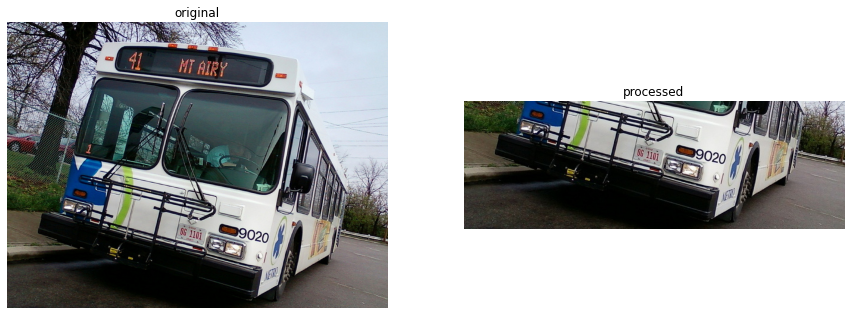

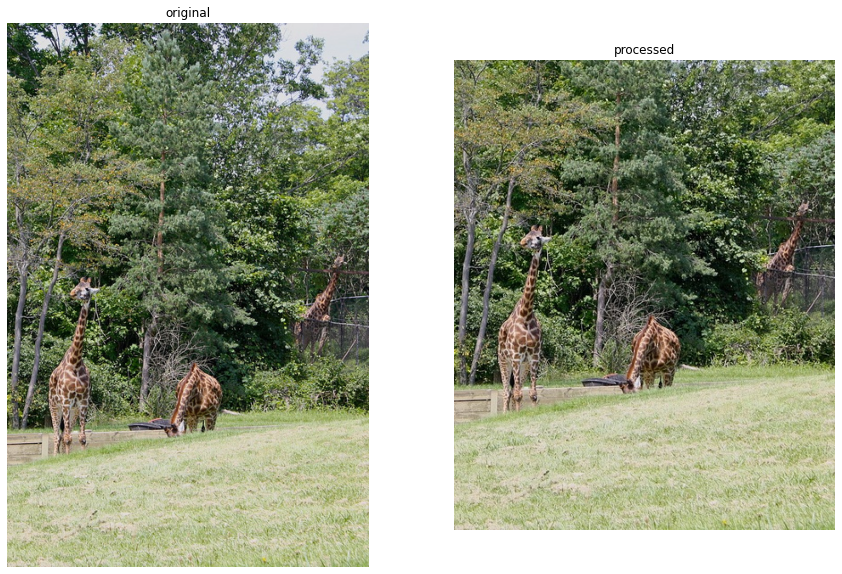

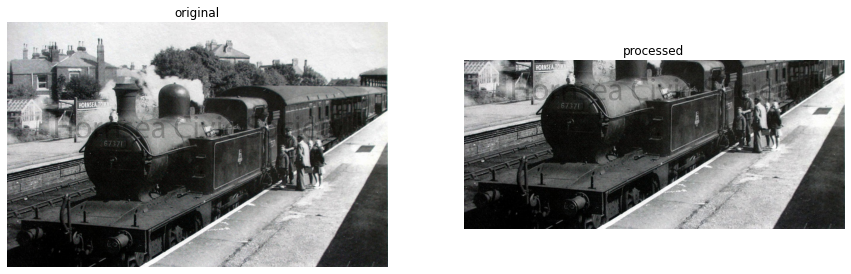

In [17]:
for duo_images in random.sample(images_with_partial_sky, 3):
  fig = plt.figure(figsize=(15, 10))

  im_orig = cv2.imread(duo_images[0])
  im_proc = cv2.imread(duo_images[1])
  fig.add_subplot(1, 2, 1)
  plt.imshow(cv2.cvtColor(im_orig, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.title("original")
  fig.add_subplot(1, 2, 2)
  plt.imshow(cv2.cvtColor(im_proc, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.title("processed")
  plt.tight_layout
  plt.show;

## Visualize panoptic segmentation:

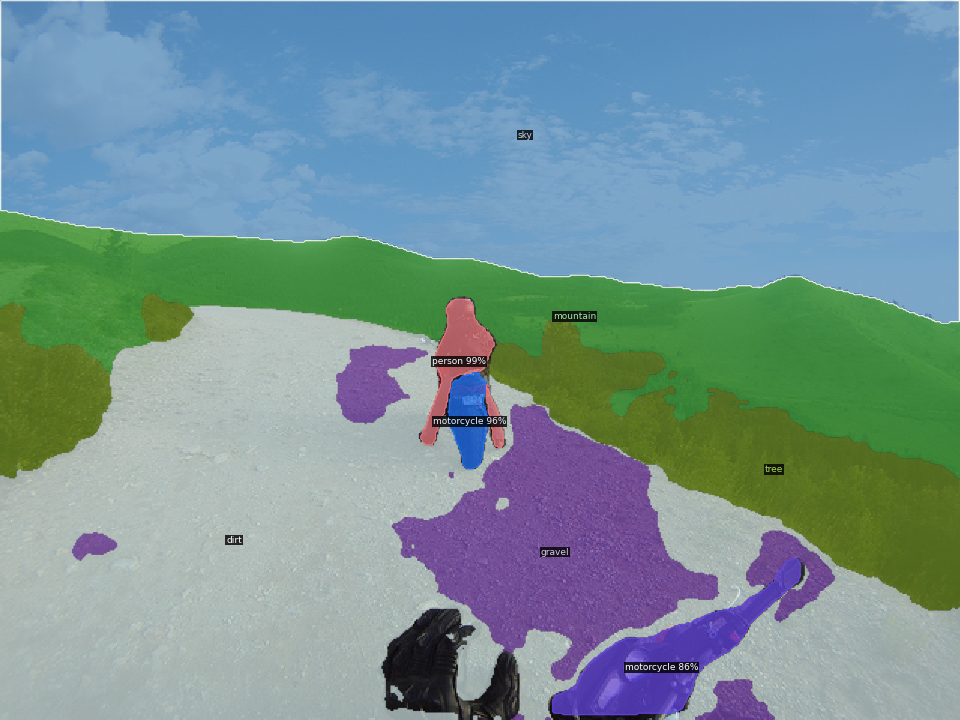

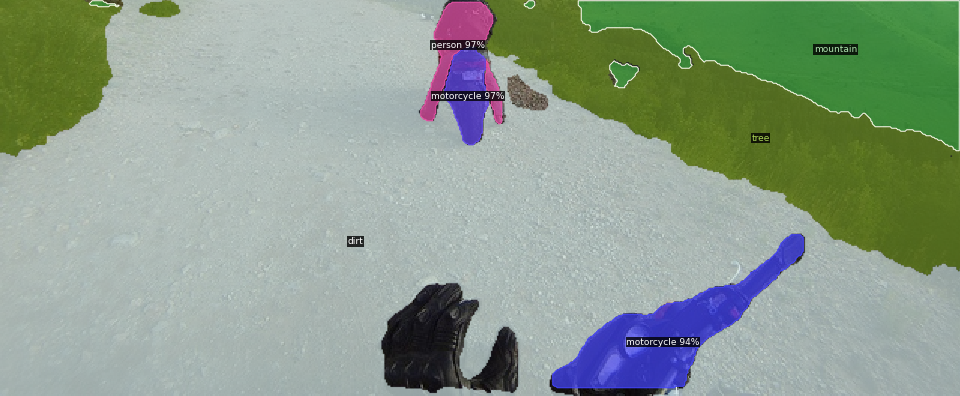

In [18]:
visualize(images_with_partial_sky , cfg, predictor,"panoptic", 1)

## Visualize object detection:

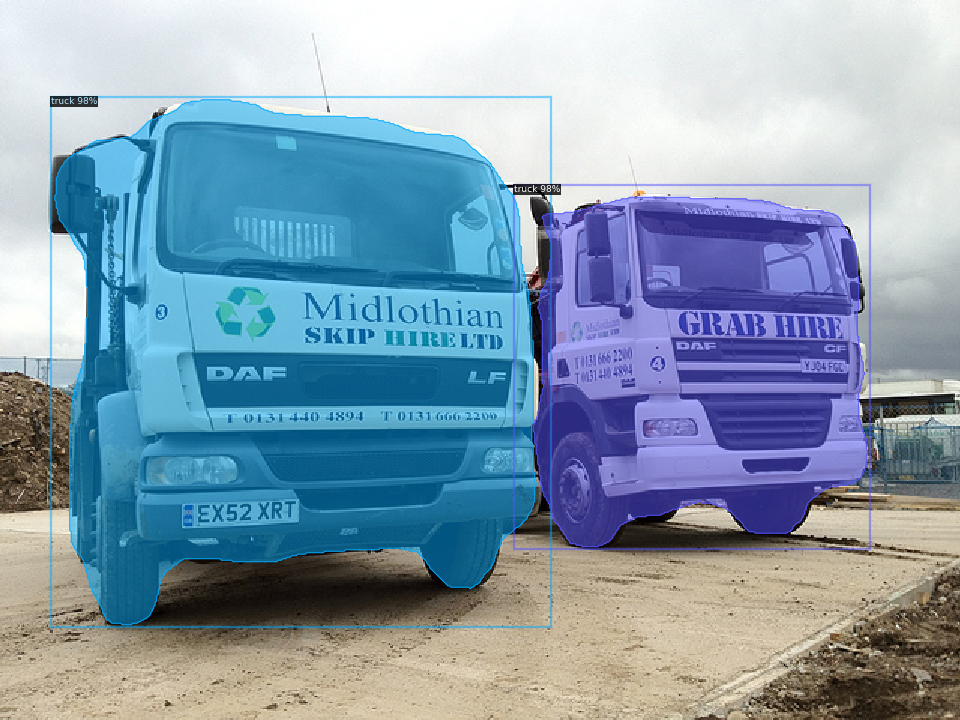

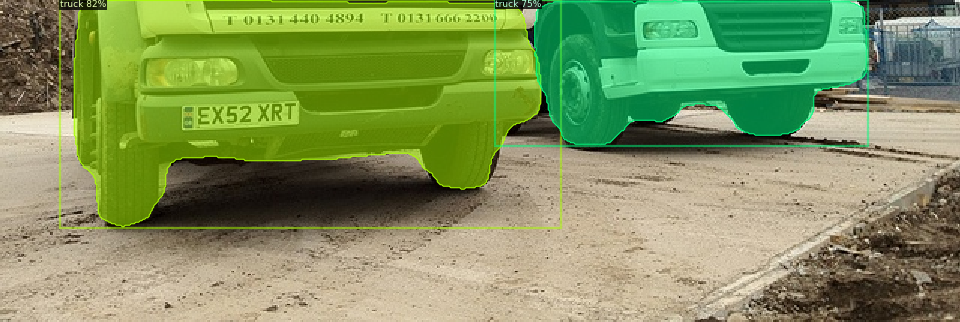

In [19]:
visualize(images_with_partial_sky , cfg_od, predictor_od,"object detection", 1)